## Setup

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("style.mplstyle")
from preprocessing import get_models_and_soups_df

In [47]:
soups, models_df = get_models_and_soups_df()
# same_model_variant = soups[soups['variant_a'] == soups['variant_b']].copy()

## Full CDF

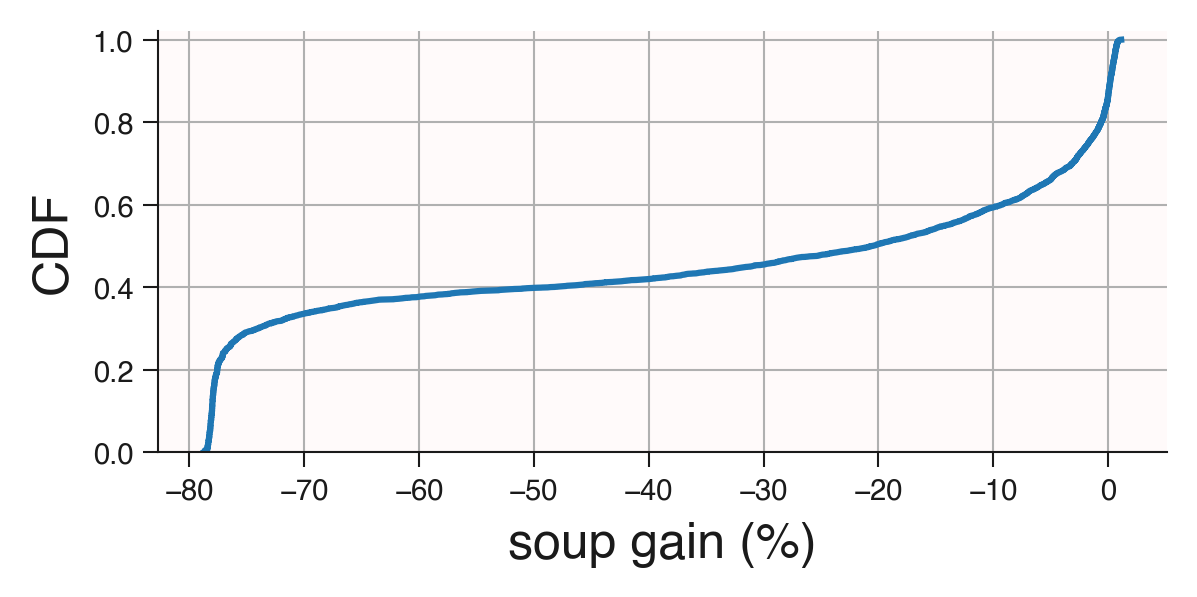

In [109]:
# soup gains (percentage points) over all rows
g = soups['acc_gain_vs_best_parent'].dropna().to_numpy()

g_sorted = np.sort(g)
cdf = np.arange(1, g_sorted.size + 1) / g_sorted.size

fig, ax = plt.subplots(figsize=(4,2))
ax.plot(g_sorted, cdf)

ax.set_xlabel('soup gain (%)', fontsize=12)
ax.set_ylabel('CDF', fontsize=12)
ax.set_ylim(0, 1.02)

plt.tight_layout()
plt.savefig('../iclr_report/figures/prob_acc_gain_vs_shared_epochs_cdf.pdf')
plt.show()


In [54]:
# soup gains in percentage points
g = soups['acc_gain_vs_best_parent'].dropna().to_numpy()

# 5 roughly equally spaced quantiles of the CDF
q_levels = [0.1, 0.3, 0.5, 0.7, 0.9]
k_list = np.quantile(g, q_levels)

k_list


array([-78.04, -74.02, -20.55,  -3.15,   0.19])

## Soup Gain (Acc) Countours

In [95]:
soups['acc_gain_vs_best_parent'] = (
    soups['clean_accuracy']
    - soups[['clean_accuracy_a', 'clean_accuracy_b']].max(axis=1)
)


In [110]:
k_list = [-50, -5, 0, 0.5]
g = soups['acc_gain_vs_best_parent'].dropna().to_numpy()
g_sorted = np.sort(g)

cdf_pos = np.array([(g_sorted <= k).mean() for k in k_list])  # in [0,1]
q_min, q_max = cdf_pos.min(), cdf_pos.max()
q_scaled = (cdf_pos - q_min) / (q_max - q_min)

In [111]:
prob_df = soups.groupby('shared_epochs').size().to_frame('n')

for k in k_list:
    prob_df[f'{k}%'] = soups['acc_gain_vs_best_parent'].gt(k).groupby(soups['shared_epochs']).mean()

prob_wide = prob_df.reset_index().sort_values('shared_epochs')
cols_data = [f'{k:g}%' for k in k_list] 


In [117]:
B = 1000
alpha = 0.05

rows = []

np.random.seed(42)

for se, g_se in soups.groupby('shared_epochs'):
    gains = g_se['acc_gain_vs_best_parent'].to_numpy()
    n = gains.size

    for k in k_list:
        # bootstrap resampling
        boot_p = []
        for _ in range(B):
            samp = np.random.choice(gains, size=n, replace=True)
            boot_p.append((samp > k).mean())

        lo, hi = np.quantile(boot_p, [alpha/2, 1 - alpha/2])
        phat = (gains > k).mean()

        rows.append({
            'shared_epochs': se,
            'k': k,
            'p': phat,
            'lo': lo,
            'hi': hi
        })

boot_df = pd.DataFrame(rows).sort_values('shared_epochs')

In [118]:
import colorsys
from matplotlib.colors import ListedColormap
import numpy as np

def red_magenta_blue(n=256, s=0.9, v=0.9):
    # hue goes 1.0 (red) -> 2/3 (blue), passing through magenta
    hs = (1.0 - np.linspace(0, 1, n) / 3.0) % 1.0
    colors = [colorsys.hsv_to_rgb(float(h), s, v) for h in hs]
    return ListedColormap(colors)

cmap = red_magenta_blue(s=0.85, v=0.85)
norm = plt.Normalize(0, 1)


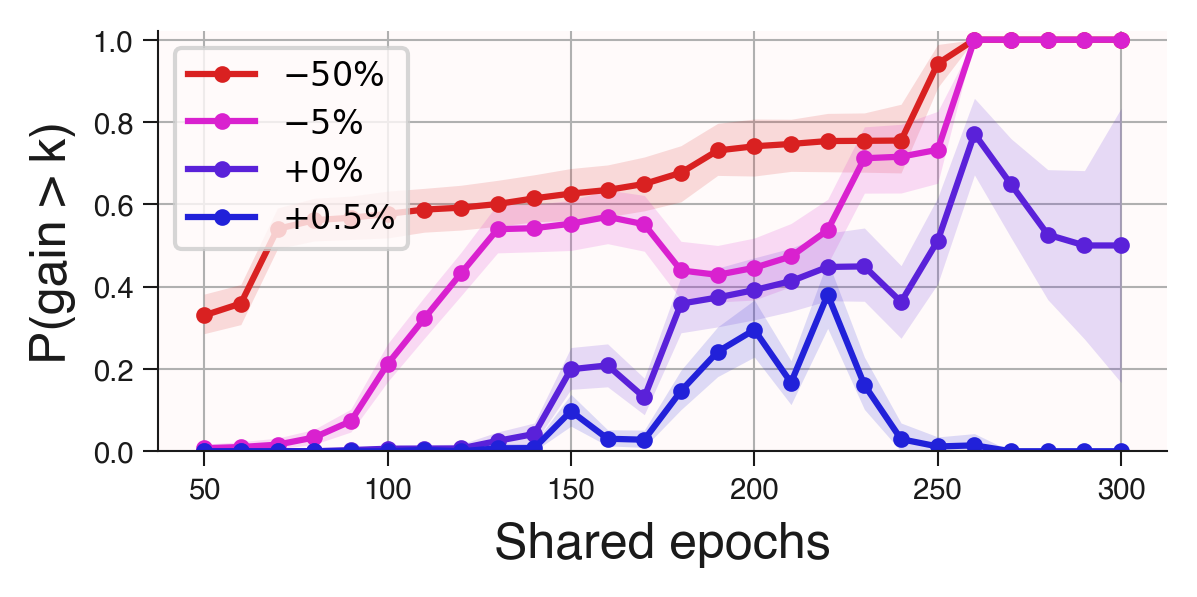

In [119]:
fig, ax = plt.subplots(figsize=(4, 2))

for k, q in zip(k_list, q_scaled):
    df_k = boot_df[boot_df['k'] == k]

    ax.plot(
        df_k['shared_epochs'],
        df_k['p'],
        marker='o',
        markersize=3,
        color=cmap(norm(q)),
        label=fmt_k(k)
    )
    ax.fill_between(
        df_k['shared_epochs'],
        df_k['lo'],
        df_k['hi'],
        color=cmap(norm(q)),
        alpha=0.15,
        linewidth=0
    )

ax.set_xlabel('Shared epochs', fontsize=12)
ax.set_ylabel('P(gain > k)', fontsize=12)
ax.set_ylim(0, 1.02)
ax.legend(frameon=True, loc='upper left', fontsize=8)
plt.tight_layout()
plt.savefig('../iclr_report/figures/prob_acc_gain_vs_shared_epochs_contours.pdf')
plt.show()

## Probability of souping being good

In [7]:
soups.columns

Index(['key_a', 'key_b', 'epoch_a', 'variant_a', 'epoch_b', 'variant_b',
       'shared_epochs', 'clean_accuracy', 'clean_loss', 'corrupted_accuracy',
       'corrupted_loss', 'clean_accuracy_permuted', 'clean_loss_permuted',
       'l2_distance', 'cosine_similarity', 'cka_logits', 'mse_logits',
       'kl_logits', 'cka_features', 'clean_loss_a', 'clean_accuracy_a',
       'clean_loss_b', 'clean_accuracy_b', 'corrupted_loss_a',
       'corrupted_loss_b', 'soup_gain', 'permutated_gain', 'corrupted_gain',
       'prob_gain_at_least_-10', 'prob_gain_at_least_-5',
       'prob_gain_at_least_0', 'prob_gain_at_least_0.1',
       'prob_gain_at_least_0.5', 'prob_gain_at_least_1'],
      dtype='object')

In [36]:
# Indicator for positive gain
soups['gain_positive'] = soups['soup_gain'] >= 0

# Probability of positive gain for each shared epoch count
prob_df = (
    soups
    .groupby('shared_epochs')['gain_positive']
    .mean()
    .reset_index()
    .rename(columns={'gain_positive': 'prob_positive_gain'})
)

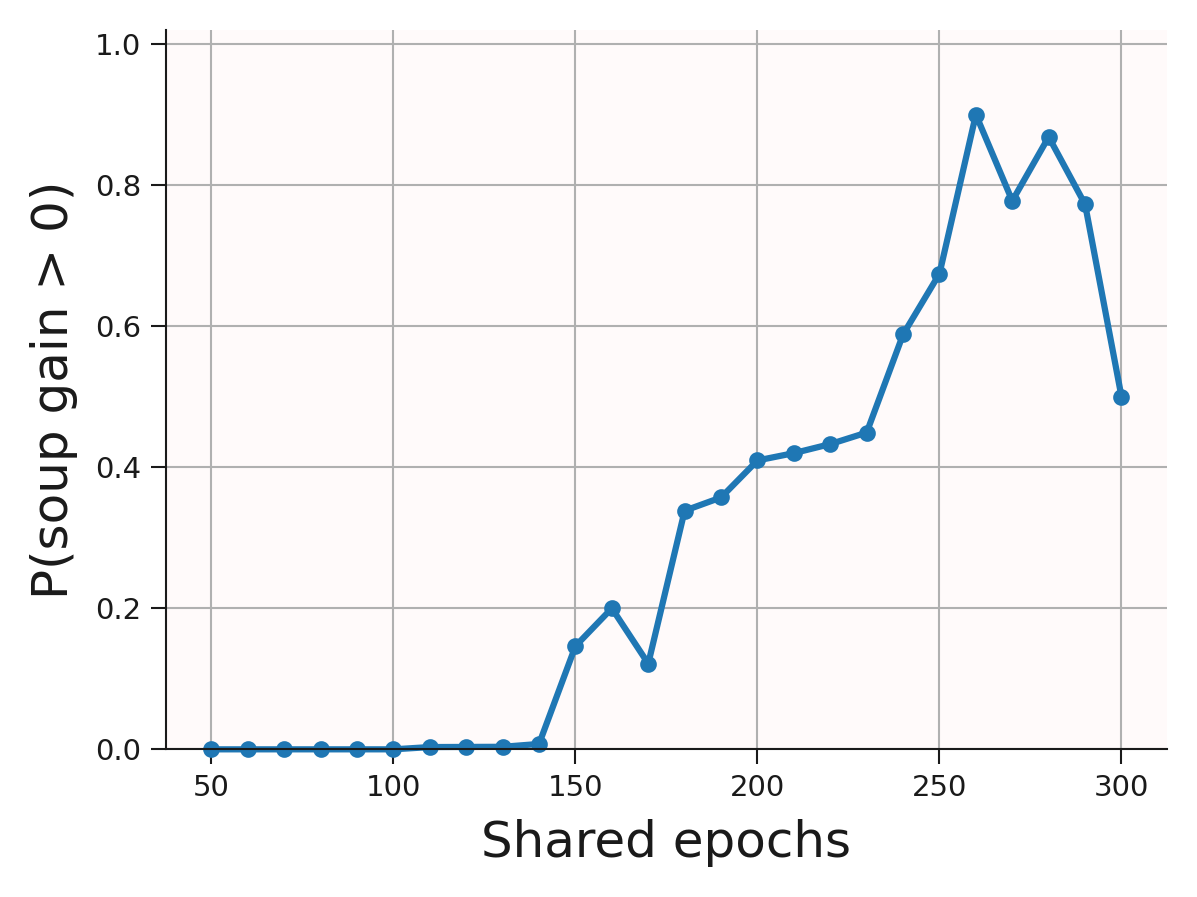

<Figure size 1200x900 with 0 Axes>

In [37]:
fig, ax = plt.subplots()

ax.plot(
    prob_df['shared_epochs'],
    prob_df['prob_positive_gain'],
    marker='o',
    markersize=3,
    clip_on=False
)

ax.set_xlabel('Shared epochs', fontsize=12)
ax.set_ylabel('P(soup gain > 0)', fontsize=12)
# ax.set_title('Probability of positive soup gain vs shared epochs', fontsize=13)

ax.set_ylim(0, 1.02)

plt.tight_layout()
plt.show()
plt.savefig('../iclr_report/figures/prob_positive_gain_vs_shared_epochs.pdf')

## Mean soup Gain

In [38]:
mean_gain_df = (
    soups
    .groupby('shared_epochs')['soup_gain']
    .mean()
    .reset_index()
    .rename(columns={'soup_gain': 'mean_soup_gain'})
)

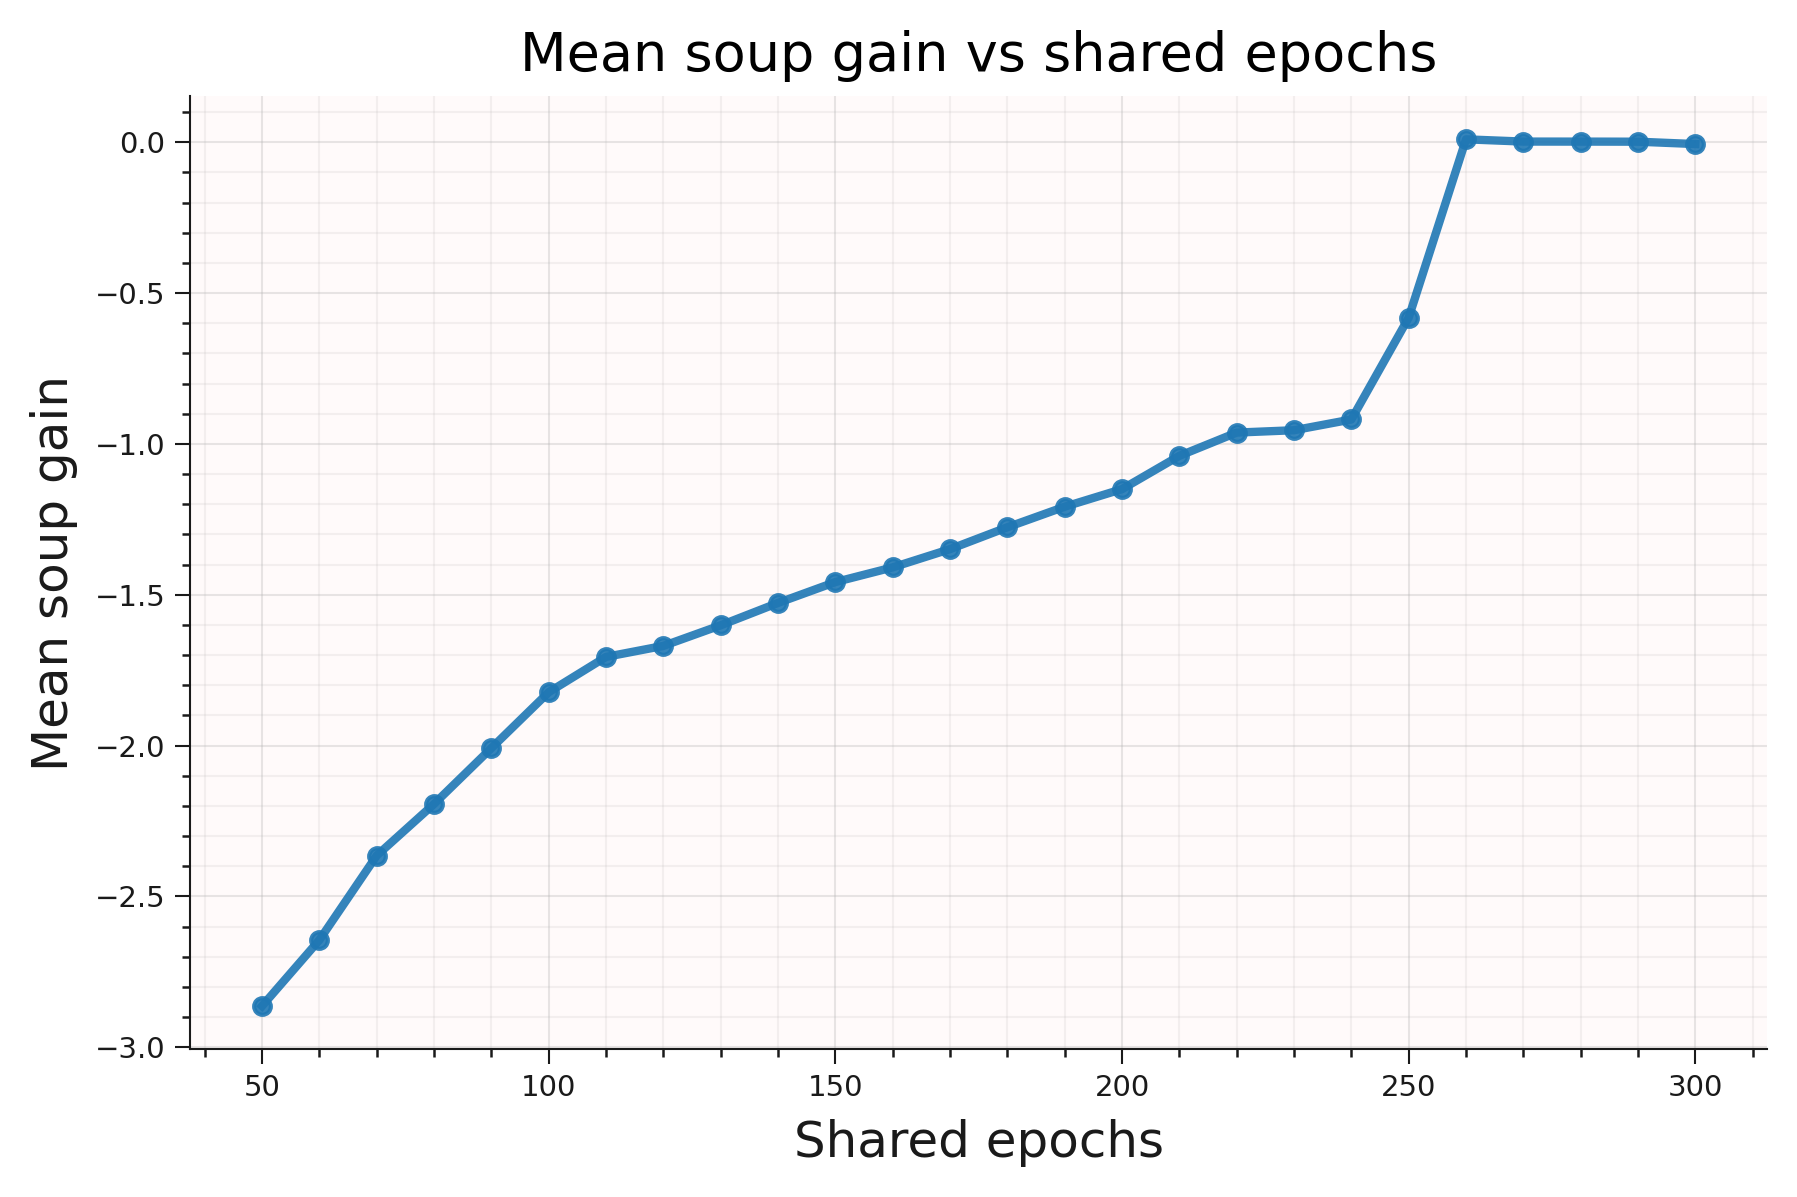

In [39]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    mean_gain_df['shared_epochs'],
    mean_gain_df['mean_soup_gain'],
    marker='o',
    markersize=4,
    linewidth=2,
    alpha=0.9
)

ax.set_xlabel('Shared epochs', fontsize=12)
ax.set_ylabel('Mean soup gain', fontsize=12)
ax.set_title('Mean soup gain vs shared epochs', fontsize=13)

# Light gridlines
ax.grid(True, which='major', alpha=0.3)
ax.minorticks_on()
ax.grid(True, which='minor', alpha=0.15)

plt.tight_layout()
plt.show()
# plt.savefig('../report/figures/mean_soup_gain_vs_shared_epochs.pdf')

## Soup quantiles

In [120]:
np.random.seed(42)

B = 1000
alpha = 0.05

rows = []
for se, g_se in soups.groupby('shared_epochs'):
    gains = g_se['soup_gain'].dropna().to_numpy()
    n = gains.size
    if n == 0:
        continue

    boot_q10 = np.empty(B)
    boot_q50 = np.empty(B)
    boot_q90 = np.empty(B)

    for b in range(B):
        samp = np.random.choice(gains, size=n, replace=True)
        boot_q10[b] = np.quantile(samp, 0.10)
        boot_q50[b] = np.quantile(samp, 0.50)
        boot_q90[b] = np.quantile(samp, 0.90)

    rows.append({
        'shared_epochs': se,
        'q10_lo': np.quantile(boot_q10, alpha/2),
        'q10_hi': np.quantile(boot_q10, 1 - alpha/2),
        'median_lo': np.quantile(boot_q50, alpha/2),
        'median_hi': np.quantile(boot_q50, 1 - alpha/2),
        'q90_lo': np.quantile(boot_q90, alpha/2),
        'q90_hi': np.quantile(boot_q90, 1 - alpha/2),
        'n': n
    })

ci_df = pd.DataFrame(rows)

q_df = (
    soups
    .groupby('shared_epochs')['soup_gain']
    .quantile([0.1, 0.5, 0.9])
    .unstack()
    .rename(columns={0.1: 'q10', 0.5: 'median', 0.9: 'q90'})
    .reset_index()
)

q_df = q_df.merge(ci_df, on='shared_epochs', how='left').sort_values('shared_epochs')


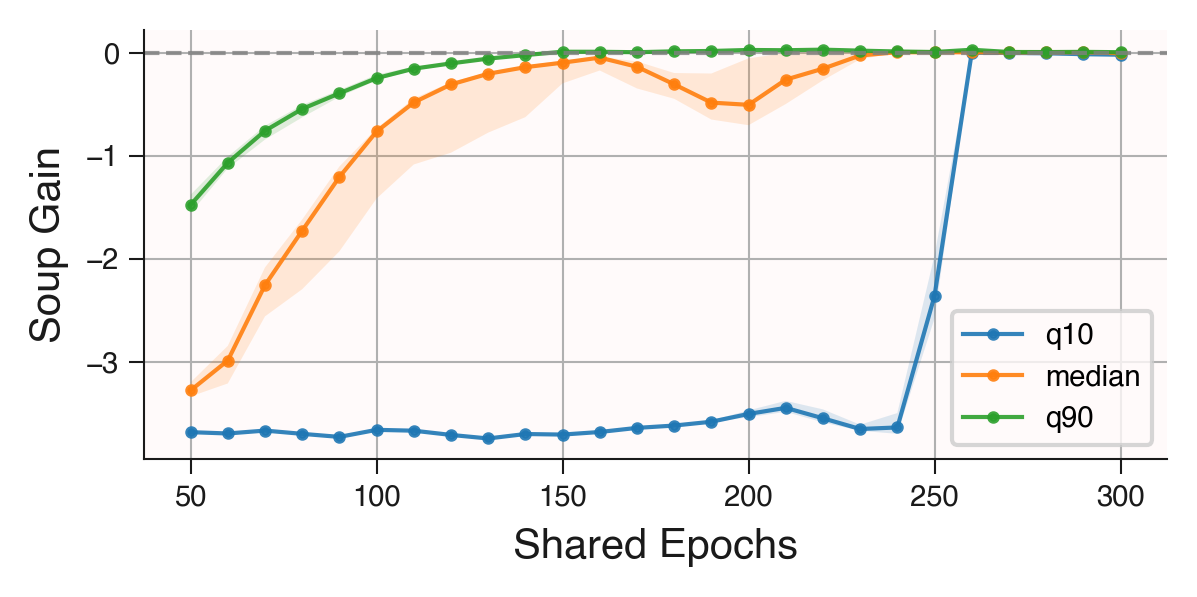

In [123]:
fig, ax = plt.subplots(figsize=(4,2))

ax.plot(q_df['shared_epochs'], q_df['q10'], label='q10', marker='o', markersize=2, linewidth=1, alpha=0.9)
ax.fill_between(q_df['shared_epochs'], q_df['q10_lo'], q_df['q10_hi'], alpha=0.15, linewidth=0)

ax.plot(q_df['shared_epochs'], q_df['median'], label='median', marker='o', markersize=2, linewidth=1, alpha=0.9)
ax.fill_between(q_df['shared_epochs'], q_df['median_lo'], q_df['median_hi'], alpha=0.15, linewidth=0)

ax.plot(q_df['shared_epochs'], q_df['q90'], label='q90', marker='o', markersize=2, linewidth=1, alpha=0.9)
ax.fill_between(q_df['shared_epochs'], q_df['q90_lo'], q_df['q90_hi'], alpha=0.15, linewidth=0)

ax.axhline(0, linewidth=1, alpha=0.8, color='gray', linestyle='--')

ax.set_xlabel('Shared Epochs', fontsize=10)
ax.set_ylabel('Soup Gain', fontsize=10)
ax.legend(frameon=True)

plt.tight_layout()
plt.savefig('../iclr_report/figures/soup_gain_quantiles_vs_shared_epochs_with_ci.pdf')
plt.show()

## Conditional expected souping performance +ve/-ve

In [127]:
soups["soup_gain_acc"] = soups["clean_accuracy"] - soups[["clean_accuracy_a", "clean_accuracy_b"]].max(axis=1)

In [128]:
np.random.seed(42)

B = 1000
alpha = 0.05

rows = []
for se, g_se in soups.groupby('shared_epochs'):
    gains = g_se['soup_gain_acc'].dropna().to_numpy()
    n = gains.size
    if n == 0:
        continue

    boot_p = np.empty(B)
    boot_mpos = np.empty(B)

    for b in range(B):
        samp = np.random.choice(gains, size=n, replace=True)
        boot_p[b] = (samp > 0).mean()
        samp_pos = samp[samp > 0]
        boot_mpos[b] = samp_pos.mean() if samp_pos.size > 0 else np.nan

    rows.append({
        'shared_epochs': se,
        'p_pos': (gains > 0).mean(),
        'p_lo': np.quantile(boot_p, alpha/2),
        'p_hi': np.quantile(boot_p, 1 - alpha/2),
        'mean_pos': gains[gains > 0].mean() if np.any(gains > 0) else np.nan,
        'mpos_lo': np.nanquantile(boot_mpos, alpha/2),
        'mpos_hi': np.nanquantile(boot_mpos, 1 - alpha/2),
        'n': n
    })

ci_df = pd.DataFrame(rows).sort_values('shared_epochs')


/Users/pierrelardet/too-salty/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1598: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


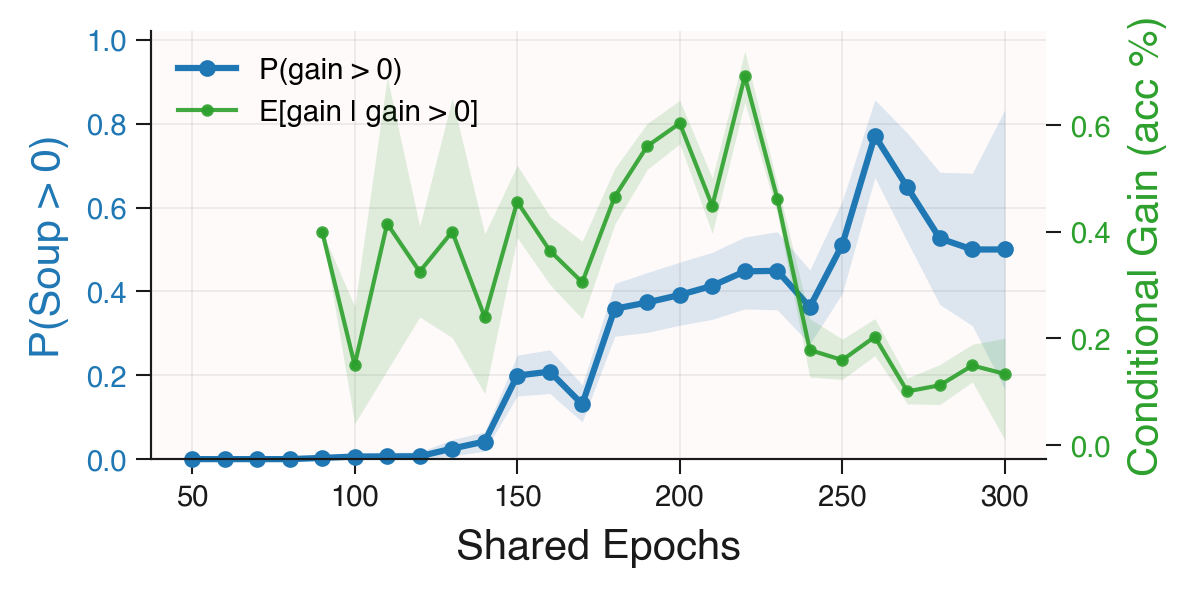

In [130]:
fig, ax1 = plt.subplots(figsize=(4,2))

# Left axis: P(gain > 0) with 95% bootstrap CI
ax1.plot(
    ci_df['shared_epochs'],
    ci_df['p_pos'],
    marker='o',
    markersize=3,
    clip_on=False,
    color='tab:blue',
    label='P(gain > 0)'
)
ax1.fill_between(
    ci_df['shared_epochs'],
    ci_df['p_lo'],
    ci_df['p_hi'],
    color='tab:blue',
    alpha=0.15,
    linewidth=0
)

ax1.set_xlabel('Shared Epochs', fontsize=10)
ax1.set_ylabel('P(Soup > 0)', fontsize=10, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 1.02)
ax1.grid(True, which='both', axis='both', linestyle='-', linewidth=0.4, alpha=0.25)

# Right axis: E[gain | gain > 0] with 95% bootstrap CI
ax2 = ax1.twinx()

ax2.plot(
    ci_df['shared_epochs'],
    ci_df['mean_pos'],
    marker='o',
    markersize=2,
    linewidth=1,
    alpha=0.9,
    color='tab:green',
    label='E[gain | gain > 0]'
)
ax2.fill_between(
    ci_df['shared_epochs'],
    ci_df['mpos_lo'],
    ci_df['mpos_hi'],
    color='tab:green',
    alpha=0.15,
    linewidth=0
)

ax2.set_ylabel('Conditional Gain (acc %)', fontsize=10, color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.grid(False)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False)

plt.tight_layout()
plt.savefig('../iclr_report/figures/combined_prob_and_conditional_gain_with_ci.pdf')
plt.show()

## Model Collapse

In [139]:
np.random.seed(42)

B = 1000
alpha = 0.05

rows = []
for se, g_se in soups.groupby('shared_epochs'):
    collapse = (g_se['clean_accuracy'].to_numpy() < 5)
    neg_gain = (g_se['soup_gain'].to_numpy() < 0)

    n = collapse.size
    if n == 0:
        continue

    boot_pc = np.empty(B)
    boot_png = np.empty(B)

    for b in range(B):
        idx = np.random.randint(0, n, size=n)  # bootstrap indices
        boot_pc[b] = collapse[idx].mean()
        boot_png[b] = neg_gain[idx].mean()

    rows.append({
        'shared_epochs': se,
        'p_collapse': collapse.mean(),
        'p_collapse_lo': np.quantile(boot_pc, alpha/2),
        'p_collapse_hi': np.quantile(boot_pc, 1 - alpha/2),
        'p_neg_gain': neg_gain.mean(),
        'p_neg_gain_lo': np.quantile(boot_png, alpha/2),
        'p_neg_gain_hi': np.quantile(boot_png, 1 - alpha/2),
        'n': n
    })

ci_df = pd.DataFrame(rows).sort_values('shared_epochs')

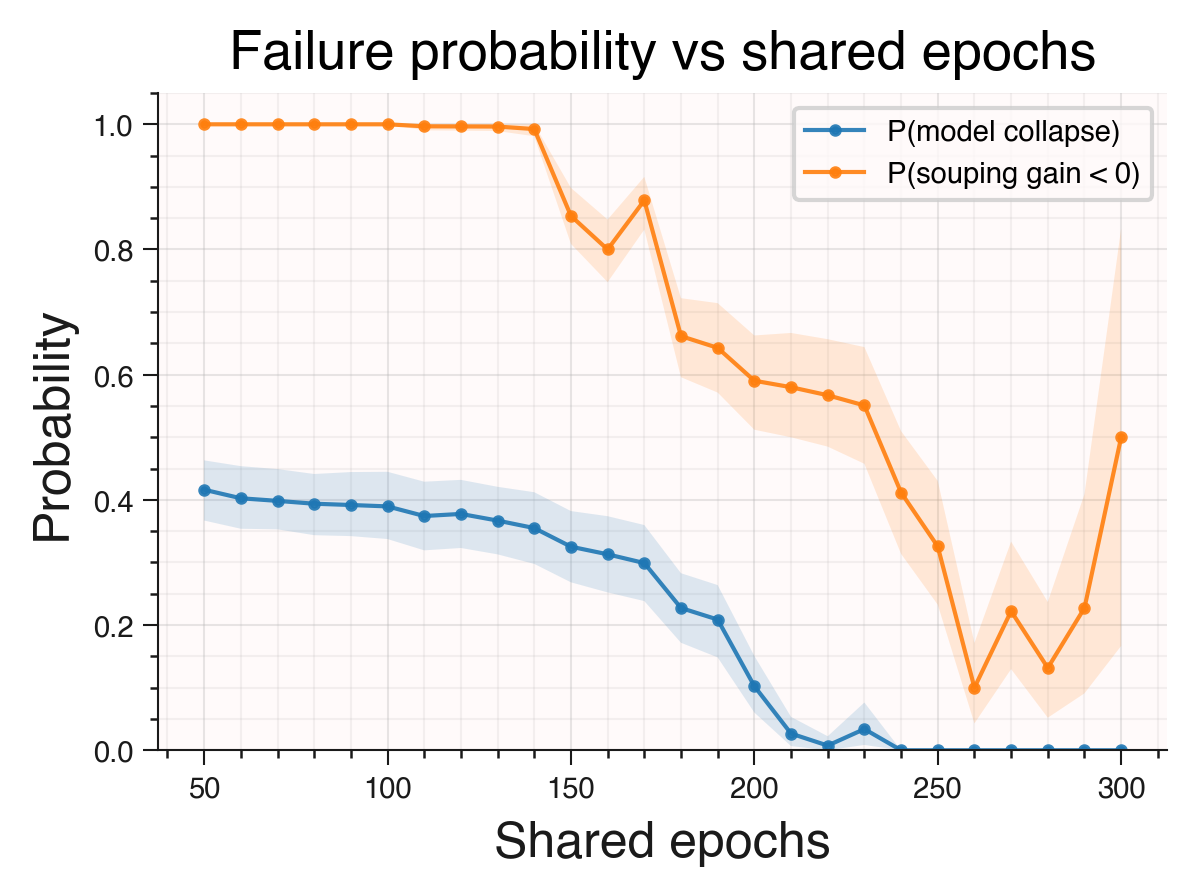

<Figure size 1200x900 with 0 Axes>

In [142]:
fig, ax = plt.subplots()

ax.plot(
    ci_df['shared_epochs'],
    ci_df['p_collapse'],
    marker='o',
    markersize=2,
    linewidth=1,
    alpha=0.9,
    label='P(model collapse)'
)
ax.fill_between(
    ci_df['shared_epochs'],
    ci_df['p_collapse_lo'],
    ci_df['p_collapse_hi'],
    alpha=0.15,
    linewidth=0
)

ax.plot(
    ci_df['shared_epochs'],
    ci_df['p_neg_gain'],
    marker='o',
    markersize=2,
    linewidth=1,
    alpha=0.9,
    label='P(souping gain < 0)'
)
ax.fill_between(
    ci_df['shared_epochs'],
    ci_df['p_neg_gain_lo'],
    ci_df['p_neg_gain_hi'],
    alpha=0.15,
    linewidth=0
)

ax.set_xlabel('Shared epochs', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.set_title('Failure probability vs shared epochs', fontsize=13)
ax.set_ylim(0, 1.05)

ax.grid(True, which='major', alpha=0.3)
ax.minorticks_on()
ax.grid(True, which='minor', alpha=0.15)

ax.legend()

plt.tight_layout()
plt.show()
plt.savefig('../iclr_report/figures/model_collapse_vs_shared_epochs_with_ci.pdf')